In [18]:
import os

In [19]:
import numpy as np
import keras
import cv2 as cv

In [20]:
from models.SegNet import seg_net
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical  
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop
import matplotlib.pyplot as plt

In [21]:
import tensorflow as tf
from keras.utils import multi_gpu_model
import json

In [22]:
labels = os.listdir('masks')

In [23]:
from utilities import *

In [24]:
def generateData( labels , batch_size = 1 , train_path = './_train/',
                train_label_path = './masks/', img_w = 256, img_h = 256, n_classes = 47):  

    while True:  
        train_data = []  
        train_label = []  
        batch = 0  
        for i in (range(len(labels))): 
            uri = labels[i]
            batch += 1 
            img = load_image(replace_ext(train_path + uri) , shape=(img_w, img_h))
            train_data.append(img)  
            mask = load_image(train_label_path + uri, True, shape=(img_w, img_h))
            mask = mask.reshape((img_w * img_h,))  
            train_label.append(mask)  
            
            
            if batch % batch_size == 0: 
                train_data = np.array(train_data)  
                #weights = get_weights(np.array(train_label))
                train_label = np.array(train_label).flatten()
                train_label = to_categorical(train_label, num_classes= n_classes)  
                train_label = train_label.reshape( ( batch_size, img_w , img_h , n_classes ) )  
                yield (train_data,train_label)
                train_data = []  
                train_label = []  
                batch = 0  

In [25]:
def testing_data_generator(labels , batch_size=3, shape=(256,256)):
    calls = 2
    counter = 1
    batch  = generateData(labels , batch_size)
    for original , masks in batch:
        print("New step.....")
        print(original.shape , masks.shape)
        
        fig, ax = plt.subplots(batch_size , 2)
        
        for idx in range(batch_size):
            ax[idx, 0].imshow(original[idx])
            ax[idx, 1].imshow( masks[idx].argmax(-1))
        
        if counter == calls:
            break #breaking generator infinite loop needed by keras
        counter += 1
        

New step.....
(3, 256, 256, 3) (3, 256, 256, 47)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


New step.....
(3, 256, 256, 3) (3, 256, 256, 47)


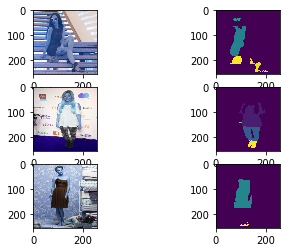

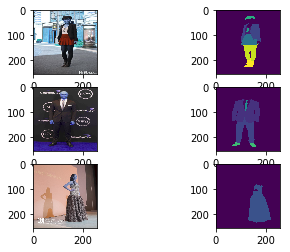

In [26]:
testing_data_generator(labels)

In [96]:
def predict_batch_images(number_of_images, model, labels, path_train = None, path_mask = None , max_image = 45625 ,
                        shape = (256,256,3) , just_return = False, seed = None):
    if path_train == None:
        path_train = "_train" + os.sep 
    
    if path_mask == None:
        path_mask = 'masks' + os.sep
    
    if seed != None:
        np.random.seed(seed)
    
    random_numbers = np.random.randint(max_image, size=(number_of_images))
        
    
    batch_prediction  = np.zeros( (number_of_images,) + shape)
    real_masks = np.zeros((number_of_images , shape[0],  shape[1]))
   
    for idx , random in enumerate(random_numbers):
        batch_prediction[idx] = load_image(path_train + replace_ext(labels[random]))
        real_masks[idx] = load_image( path_mask + labels[random] , mask=True)
    
    input_images = batch_prediction #Paint Images
    batch_prediction = model.predict(batch_prediction)
    batch_prediction = batch_prediction.argmax(-1)
    
    if not just_return:
        
        fig, ax = plt.subplots( 2 , number_of_images, figsize=(16,10), gridspec_kw = {'wspace':0, 'hspace':0})

        
        for idx in range(number_of_images):
                ax[0, idx].xaxis.set_major_locator(plt.NullLocator())
                ax[0, idx].yaxis.set_major_locator(plt.NullLocator())

                ax[1, idx].yaxis.set_major_locator(plt.NullLocator())
                ax[1, idx].xaxis.set_major_locator(plt.NullLocator())
            
                ax[0 , idx].imshow(real_masks[idx] )
                ax[1 , idx].imshow(batch_prediction[idx])
                
    
    
    return batch_prediction , real_masks, input_images

In [13]:
###GLOBAL VARIABLES , TRAINING 
FROM_TRAIN = 0
TO_TRAIN = 42000
BATCH_SIZE = 10
FROM_VAL = 42000
TO_VAL = 45000
STEPS_PER_EPOCH = (TO_TRAIN - FROM_TRAIN) // BATCH_SIZE
VALIDATION_STEPS = (TO_VAL - FROM_VAL) // BATCH_SIZE
EPOCHS = 8

In [39]:
def lets_train(model, _from_train , _to_train , batch_size, steps_per_epoch , _from_val, to_val, validation_steps, epochs, callbacks,
              shape=(224,224)):
    
    history = model.fit_generator(generateData(labels[_from_train:_to_train] , 
                                               batch_size = batch_size , 
                                               img_w = shape[0],
                                               img_h = shape[1]),
                    steps_per_epoch= steps_per_epoch,
                    validation_data= generateData(labels[_from_val:to_val]),
                    validation_steps= validation_steps,
                    epochs = epochs,
                    callbacks = callbacks)
    return history

In [40]:
def get_callbacks(model_name):
    csv_logger = CSVLogger(model_name + 'training.log')
    check_point = ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}'+ model_name + '.hdf5')
    return [csv_logger, check_point]

In [28]:
segnet_model = seg_net((256,256,3))

Instructions for updating:
Colocations handled automatically by placer.


In [29]:
#optimizer = Adam(lr=0.004)
segnet_model.compile(loss='categorical_crossentropy' ,optimizer='sgd',metrics=['accuracy' , i_over_u ])

In [30]:
segnet_model.load_weights('checkpoints/weights.04-0.50segnet.hdf5')

In [ ]:
history = lets_train(model = segnet_model, 
                     _from_train=FROM_TRAIN, 
                     _to_train=TO_TRAIN, 
                     batch_size=BATCH_SIZE, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     validation_steps=VALIDATION_STEPS, 
                     _from_val=FROM_VAL, to_val=TO_VAL, 
                     epochs = EPOCHS , 
                     shape = (256,256),
                     callbacks = get_callbacks('segnet'))

Epoch 1/8
  89/4200 [..............................] - ETA: 3:21:01 - loss: 0.1252 - acc: 0.9596 - i_over_u: 0.8649

In [ ]:
draw_results(history)

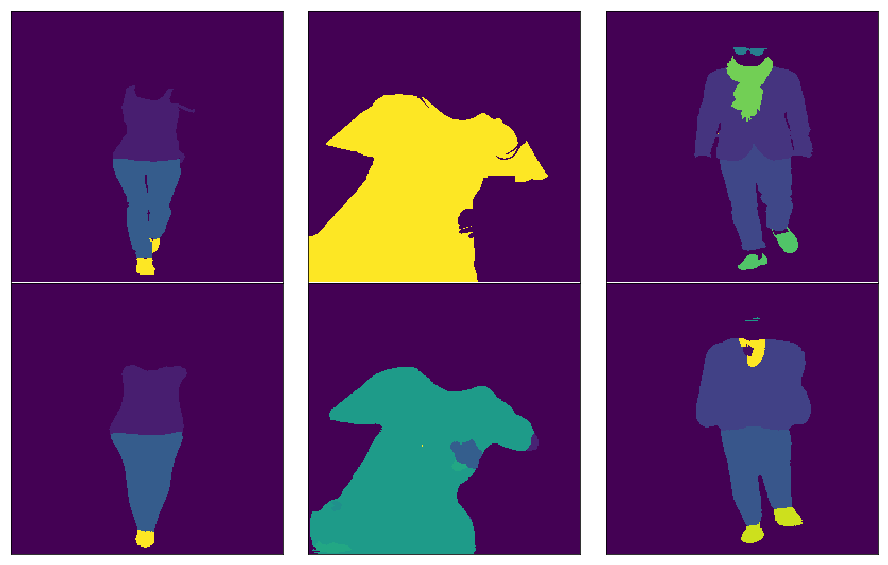

In [23]:
_, _ = predict_batch_images(model = segnet_model ,labels=labels, number_of_images=3)

In [20]:
from models.Unet import Unet

In [21]:
unet_model = Unet(n_label=47, input_size=(256,256,3))
unet_model = unet_model.get_model()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/hcastro/moda_dataset/models/Unet.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  self.model = Model(input = inputs, output = activated)


In [22]:
unet_model.compile(loss='categorical_crossentropy' ,optimizer='adam',metrics=['accuracy' , i_over_u] )  

In [23]:
history = lets_train(model = unet_model, 
                     _from_train=FROM_TRAIN, 
                     _to_train=TO_TRAIN, 
                     batch_size=BATCH_SIZE, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     validation_steps=VALIDATION_STEPS, 
                     _from_val=FROM_VAL, to_val=TO_VAL, 
                     epochs = EPOCHS , 
                     shape = (256,256),
                     callbacks = None)

Epoch 1/3
100/100 [==============================] - 34s 335ms/step - loss: 1.7802 - acc: 0.8821 - i_over_u: 0.0011 - val_loss: 1.7479 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00
Epoch 2/3
100/100 [==============================] - 27s 270ms/step - loss: 1.7479 - acc: 0.8916 - i_over_u: 0.0000e+00 - val_loss: 1.7479 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00
Epoch 3/3
100/100 [==============================] - 27s 267ms/step - loss: 1.7479 - acc: 0.8916 - i_over_u: 0.0000e+00 - val_loss: 1.7479 - val_acc: 0.8916 - val_i_over_u: 0.0000e+00


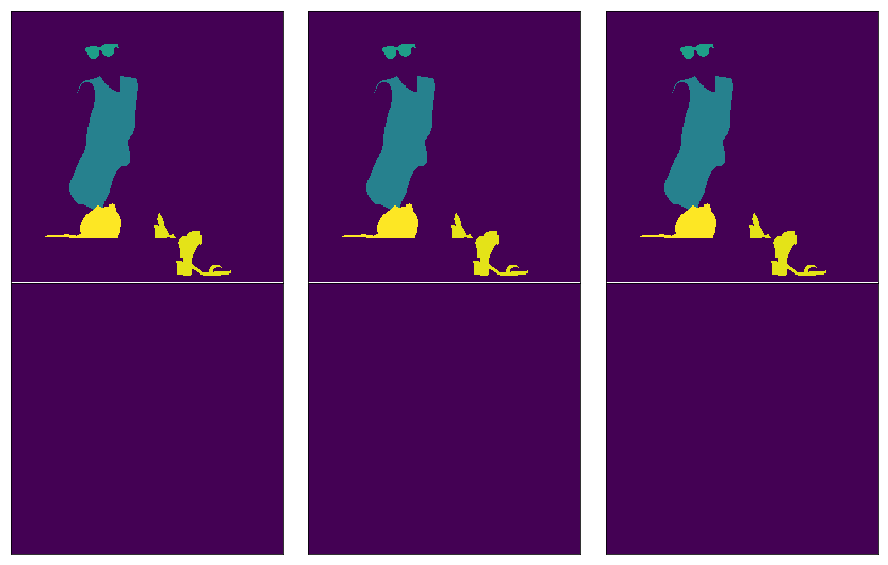

In [25]:
_, _ = predict_batch_images(model = unet_model ,labels=labels, number_of_images=3, max_image=1)

# TransferLearning

In [31]:
import sys
sys.path.insert(0, 'models/')

In [32]:
from models.FCN import *
from models.utils.loss_function import softmax_sparse_crossentropy_ignoring_last_label

In [33]:
atrous_resnet50_model = AtrousFCN_Resnet50_16s(input_shape=(256,256,3) , classes=47)

In [34]:
atrous_resnet50_model.compile(loss='categorical_crossentropy' ,optimizer='sgd',metrics=['accuracy'])

In [35]:
atrous_resnet50_model.load_weights('checkpoints/weights.04-0.37atrous_resnet50_last.hdf5')

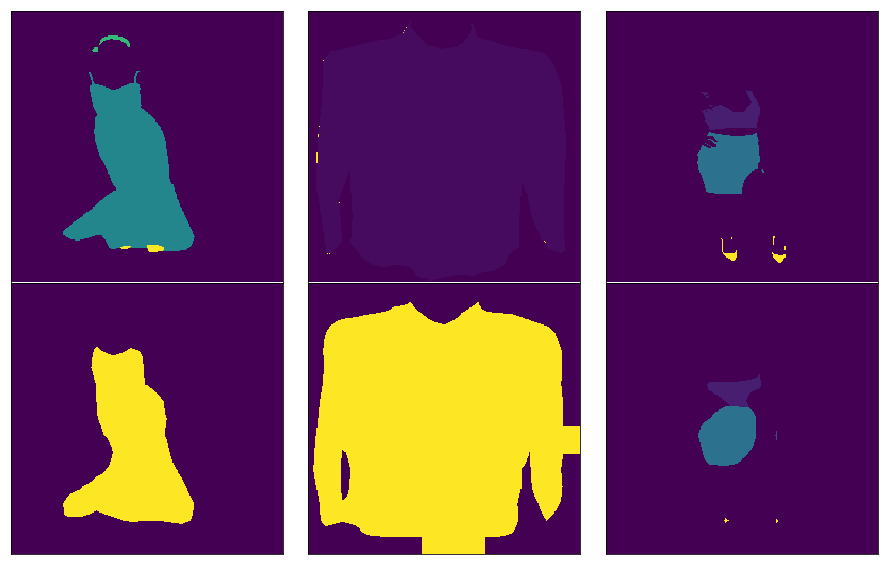

In [30]:
_, _ = predict_batch_images(model = atrous_resnet50_model ,labels=labels, number_of_images=3)

In [36]:
history = lets_train(model = atrous_resnet50_model, 
                     _from_train=FROM_TRAIN, 
                     _to_train=TO_TRAIN, 
                     batch_size=BATCH_SIZE, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     validation_steps=VALIDATION_STEPS, 
                     _from_val=FROM_VAL, to_val=TO_VAL, 
                     epochs = EPOCHS,
                     shape = (256,256),
                     callbacks = get_callbacks('atrous_resnet50'))

Epoch 1/3
100/100 [==============================] - 26s 256ms/step - loss: 0.1420 - acc: 0.9657 - val_loss: 0.0460 - val_acc: 0.9818
Epoch 2/3
100/100 [==============================] - 15s 147ms/step - loss: 0.0427 - acc: 0.9829 - val_loss: 0.0424 - val_acc: 0.9826
Epoch 3/3
100/100 [==============================] - 14s 141ms/step - loss: 0.0405 - acc: 0.9834 - val_loss: 0.0407 - val_acc: 0.9830


In [38]:
model_fcn_resnet50 = FCN_Resnet50_32s(input_shape=(256,256,3) , classes=47)

In [39]:
model_fcn_resnet50.compile(loss='categorical_crossentropy' ,optimizer='sgd',metrics=['accuracy' , i_over_u ])

In [40]:
history = lets_train(model = model_fcn_resnet50, 
                     _from_train=FROM_TRAIN, 
                     _to_train=TO_TRAIN, 
                     batch_size=BATCH_SIZE, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     validation_steps=VALIDATION_STEPS, 
                     _from_val=FROM_VAL, to_val=TO_VAL, 
                     epochs = EPOCHS , 
                     shape=(256,256),
                     callbacks = get_callbacks('fcn_resnet50'))


Epoch 1/3
100/100 [==============================] - 25s 246ms/step - loss: 9.0138 - acc: 0.1008 - i_over_u: 0.1190 - val_loss: 9.6776 - val_acc: 0.2204 - val_i_over_u: 0.1255
Epoch 2/3
100/100 [==============================] - 12s 123ms/step - loss: 9.2741 - acc: 0.1675 - i_over_u: 0.1289 - val_loss: 8.4256 - val_acc: 0.2074 - val_i_over_u: 0.1340
Epoch 3/3
100/100 [==============================] - 13s 125ms/step - loss: 9.5531 - acc: 0.2219 - i_over_u: 0.1390 - val_loss: 8.2076 - val_acc: 0.1113 - val_i_over_u: 0.1208


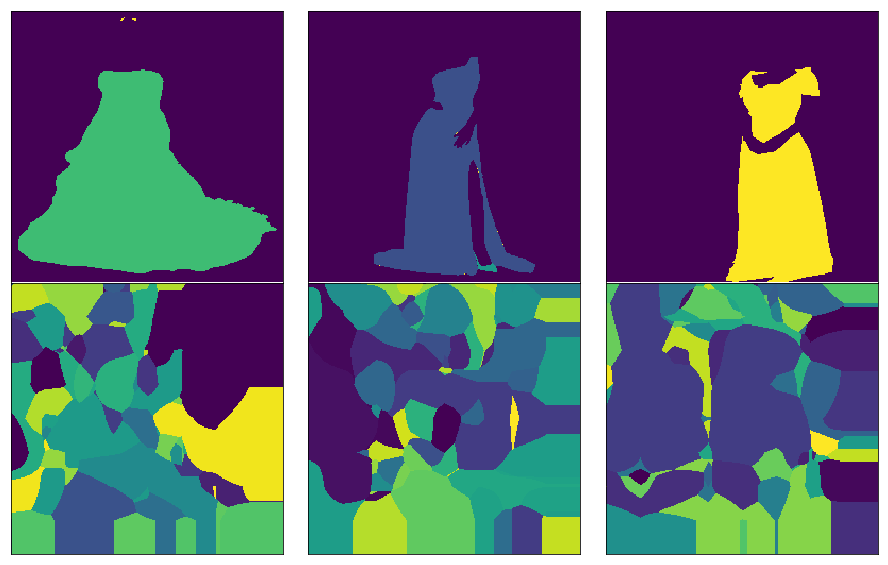

In [42]:
_, _ = predict_batch_images(model = model_fcn_resnet50 ,labels=labels, number_of_images=3, )

In [23]:
model_dense_net = DenseNet_FCN(input_shape=(256,256,3) , classes=47, activation = 'softmax')

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
model_dense_net.compile(loss=generalized_dice_loss ,optimizer='sgd',metrics=['accuracy' , i_over_u ])

(?,)


In [ ]:
history = lets_train(model = model_dense_net, 
                     _from_train=FROM_TRAIN, 
                     _to_train=TO_TRAIN, 
                     batch_size=BATCH_SIZE, 
                     steps_per_epoch=STEPS_PER_EPOCH, 
                     validation_steps=VALIDATION_STEPS, 
                     _from_val=FROM_VAL, to_val=TO_VAL, 
                     epochs = EPOCHS , 
                     shape=(256,256),
                     callbacks = get_callbacks('dense_net_wholedset'))

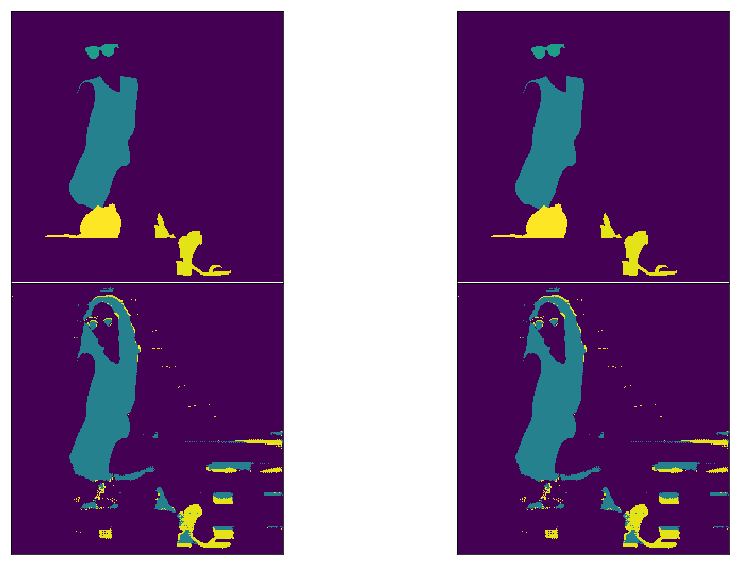

In [47]:
_, _ = predict_batch_images(model = model_dense_net ,labels=labels, number_of_images=2, max_image=1)

In [39]:
models = [ (segnet_model, 'SegNet')  , 
           #(unet_model, 'unet'), 
           (atrous_resnet50_model, 'Atrous ResNet50'),
           #( model_fcn_resnet50 , 'model_fcn_resnet50'),
           #(model_dense_net , 'model_dense_net')
         ]

In [40]:
with open('label_descriptions.json') as json_f:
    look_up_classes = json.load(json_f)
    categories = look_up_classes["categories"]

In [133]:
def get_classes(original_masks , predicted_masks , categories):
    prediction_result = []
    real_result  = [] 
    
    for idx , model in enumerate(predicted_masks):
        model_p = []
        for example in model:
            unique_values = np.unique(example)
            unique_values = unique_values[unique_values != 0]
            classes = []
            for value in unique_values:
                classes.append(categories[value-1]['name'])
            
            model_p.append(classes)
        prediction_result.append(model_p)
        
    
    
    for mask in predicted_masks[0]:
        unique_values = np.unique(mask)
        classes = []
        for value in unique_values:
            classes.append(categories[value-1]['name'])

        real_result.append(classes)
        
        
    return prediction_result, real_result

In [134]:
def compare_models(models, number_of_images=3, seed=None):
    
    number_of_models = len(models)  # +1 original image , and mask
    
    predicted_masks = []
    original_masks = []
    for model, name in models:
        result , masks, input_images = predict_batch_images(model = model ,
                                               labels=labels, 
                                               number_of_images=number_of_images, 
                                               seed = seed,
                                               just_return = True)
        
        original_masks.append(masks)
        predicted_masks.append(result)
   
    
    predicted_categories, real_categories = get_classes(original_masks , predicted_masks, categories)
    
    
    for idx , category in enumerate(predicted_categories):
        print("Model: " + models[idx][1])
        print("Predicted Categories: ")
        for j , category_image in enumerate(category):
            print("Image%d: "%j , category_image)
    
    print("Real categories")
    for idx, category in enumerate(real_categories):
        print("Image%d: "%idx , category)
         
    fig, ax = plt.subplots(  number_of_models + 2 , number_of_images,  figsize=(12,20), gridspec_kw = {'wspace':0, 'hspace':0})
    
    ax[number_of_models , 0].set_title("Original Mask", loc='left')
    ax[number_of_models+1 , 0].set_title("Original Input Images", loc='left')

    
    for i in range(number_of_models):
        ax[i , 0].set_title(models[i][1],  loc='left')            

    for i in range(number_of_models):
        for j in range(number_of_images):
            ax[i , j].xaxis.set_major_locator(plt.NullLocator())
            ax[i , j].yaxis.set_major_locator(plt.NullLocator())
            ax[i , j].imshow(predicted_masks[i][j])        

    for k in range(number_of_images):
        ax[number_of_models , k].xaxis.set_major_locator(plt.NullLocator())
        ax[number_of_models , k].yaxis.set_major_locator(plt.NullLocator())
        ax[number_of_models , k].imshow(original_masks[0][k])
    
    for j in range(number_of_images):
        ax[number_of_models + 1 , j].xaxis.set_major_locator(plt.NullLocator())
        ax[number_of_models + 1,  j ].yaxis.set_major_locator(plt.NullLocator())
        ax[number_of_models + 1, j].imshow(input_images[j])

Model: SegNet
Predicted Categories: 
Image0:  ['top, t-shirt, sweatshirt', 'jacket', 'shorts']
Image1:  ['top, t-shirt, sweatshirt', 'dress']
Image2:  ['dress']
Model: Atrous ResNet50
Predicted Categories: 
Image0:  ['top, t-shirt, sweatshirt', 'jacket', 'shorts']
Image1:  ['dress']
Image2:  ['dress', 'shoe']
Real categories
Image0:  ['tassel', 'top, t-shirt, sweatshirt', 'jacket', 'shorts']
Image1:  ['tassel', 'top, t-shirt, sweatshirt', 'dress']
Image2:  ['tassel', 'dress']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


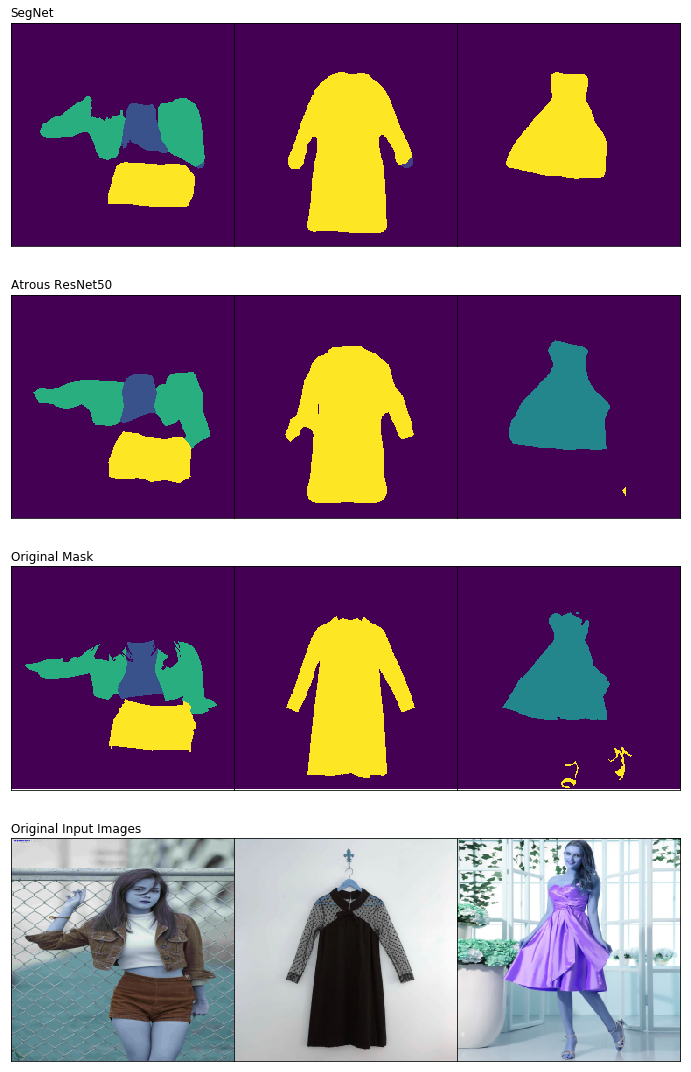

In [139]:
#0, 6, 101
compare_models(models, seed=101)